In this notebook we implement and test the sensitivity style pruning.

In [1]:
# General imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepmod_l1.diff_library import theta_analytical

#Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Remainder imports
from os import listdir, path, getcwd

# Setting cuda
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining output folder
output_folder = getcwd()

%load_ext autoreload
%autoreload 2

# Making library

In [2]:
D = 0.5
a = 0.25

x = np.linspace(-5, 5, 500, dtype=np.float32)
t = np.linspace(0, 5, 100, dtype=np.float32)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
    
# Analytical
time_deriv, theta = theta_analytical(x_grid, t_grid, D, a)

And performing lst-sq we get:

In [3]:
np.linalg.lstsq(theta, time_deriv, rcond=None)[0].squeeze()

array([-2.4918742e-17,  2.0816682e-16,  5.0000000e-01,  4.4582393e-16,
       -1.2127323e-16, -1.0972126e-16, -3.7296555e-17,  1.0139718e-16,
       -7.5894152e-17], dtype=float32)

# Standardization

Before we implement everything, let's see what the sensitivity w.r.t to each parameter actually is:

In [4]:
a = np.mean(theta, axis=0)
b = np.std(theta, axis=0)

a[0] = 0.0 # for the ones.
b[0] = 1.0

theta_standard = (theta - a)/b

In [5]:
X_train = torch.tensor(theta_standard, dtype=torch.float32)
y_train = torch.tensor(time_deriv, dtype=torch.float32)

In [6]:
model = nn.Sequential(*[nn.Linear(X_train.shape[1], 1, bias=False)])

In [7]:
optimizer = torch.optim.Adam(model.parameters())
iterations = 20000

In [8]:
for it in np.arange(iterations):
    prediction = model(X_train)
    loss = torch.mean((prediction - y_train)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it % 1000 == 0:
        print(loss.item())

0.29280346632003784
0.002768810372799635
0.00046436110278591514
0.0001673570804996416
6.68103966745548e-05
2.2659547539660707e-05
3.954592557420256e-06
2.181690064162467e-07
1.7514623085190806e-09
5.487325546206512e-13
7.922342226684975e-10
5.522628346318437e-16
1.4080227358719254e-16
1.2090078937987414e-09
4.3806785591593914e-14
6.894950647755305e-13
8.619689163824606e-12
1.419358568455209e-07
5.852316548038416e-11
4.654798681918981e-13


Loss is definitely lower, let's see about the weights:

In [9]:
xi_normalized = model[0].weight.detach().numpy().squeeze()

weights = xi_normalized.copy()
weights[0] = weights[0] - np.sum(weights[1:] * a[1:])
weights[1:] = weights[1:] / b[1:]

xi = weights

Now let's look at the sensitivity:

In [10]:
output = model(X_train)
output.backward(torch.ones_like(output))

In [11]:
model[0].weight.grad

tensor([[ 5.0000e+04,  4.4619e-03, -5.8911e-03,  5.3858e-01, -2.6307e-03,
          3.4178e-02,  2.7442e-01, -1.1156e-03,  4.8781e-02]])

In [12]:
output = model(X_train)
sensitivities = torch.autograd.grad(output, model.parameters(), torch.ones_like(output))[0].numpy().squeeze()

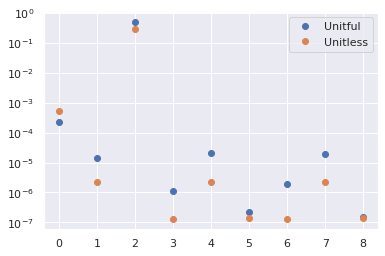

In [13]:
plt.semilogy(np.abs(xi), 'o')
plt.semilogy(np.abs(xi_normalized), 'o')

plt.legend(['Unitful', 'Unitless'])

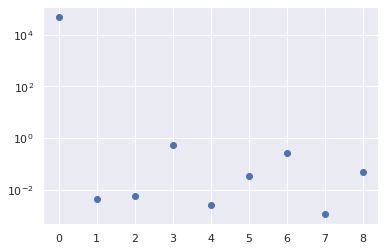

In [14]:
plt.semilogy(np.abs(sensitivities), 'o')

That doesn't seem to encouraging... What do the unnormalized sensitivities look like?

In [15]:
X_train = torch.tensor(theta, dtype=torch.float32)
y_train = torch.tensor(time_deriv, dtype=torch.float32)

In [16]:
model = nn.Sequential(*[nn.Linear(X_train.shape[1], 1, bias=False)])

In [17]:
optimizer = torch.optim.Adam(model.parameters())
iterations = 20000

In [18]:
for it in np.arange(iterations):
    prediction = model(X_train)
    loss = torch.mean((prediction - y_train)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it % 1000 == 0:
        print(loss.item())

0.06429553776979446
0.0006206107791513205
9.496667985331442e-07
1.2643771185594233e-07
3.607331677812908e-08
7.798018231142123e-09
6.249536999014538e-10
9.432878089743468e-12
1.6943928492262408e-14
1.4919435045029905e-15
5.067272433599589e-16
2.5908694389523796e-16
7.631060166151752e-24
7.465943295649489e-25
4.188568402873825e-25
7.006420222102943e-23
7.063644192167675e-23
2.185255006665449e-15
2.347591517984696e-16
3.324577822344133e-21


In [19]:
xi_unnormalized = model[0].weight.detach().numpy().squeeze()

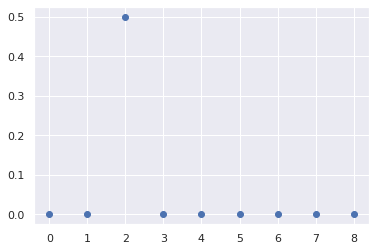

In [20]:
plt.plot(xi_unnormalized, 'o')

In [21]:
output = model(X_train)
sensitivities = torch.autograd.grad(output, model.parameters(), torch.ones_like(output))[0].numpy().squeeze()

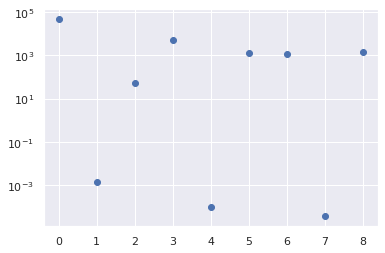

In [22]:
plt.semilogy(np.abs(sensitivities), 'o')

# Implementing 